# Amazon Reviews Sentimental Analysis using Fine-tuned GPT model

### Import packages

In [38]:
import pandas as pd
import openai
import os
from dotenv import load_dotenv
load_dotenv()
from datasets import load_dataset
import random
import math
import matplotlib.pyplot as plt

openai.api_key = os.getenv("OPENAI_API_KEY")

#### Load data

In [11]:
random.seed(42)
df = pd.read_csv('Data/areviews.csv')
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


#### Pre-process data

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Splitting into train and test sets (70% train, 30% test)
train_set, test_set = train_test_split(df, test_size=0.3, random_state=42)

# Save the train set to a CSV file
train_set.to_csv('train_amazon.csv', index=False)

# Save the test set to a CSV file
test_set.to_csv('test_amazon.csv', index=False)

In [13]:
train_set.columns

Index(['id', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'dimension', 'ean', 'keys', 'manufacturer',
       'manufacturerNumber', 'name', 'prices', 'reviews.date',
       'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'sizes',
       'upc', 'weight'],
      dtype='object')

In [14]:
training_df = train_set
val_df = test_set

In [15]:
training_df['prompt'] = training_df['reviews.title'] + '\n\n' + training_df['reviews.text'] + '\n\n###\n\n'
val_df['prompt'] = val_df['reviews.title'] + '\n\n' + val_df['reviews.text'] + '\n\n###\n\n'

In [16]:
training_df.prompt

941     Cool but its app didn't work well\n\nI like th...
363     great box for XBMC\n\nI bought it to run XBMC,...
905     Limitations\n\nThis is a fun and convenient to...
426     From a Roku 3 owner, and now Fire TV...\n\nThi...
1249    Impulse Buy\n\nI should have done some researc...
                              ...                        
1130    It has so many uses and performs well.\n\nLast...
1294    Great companion\n\nI have the have the Echo an...
860     I'm happy\n\nI really like my Tap very much. I...
1459    I hate having to shove headphones into my brai...
1126    Very decent sound and the portability is excel...
Name: prompt, Length: 1117, dtype: object

In [17]:
training_df['completion'] = ' ' + training_df['reviews.rating'].astype(str)  # for sentiment
val_df['completion'] = ' ' + val_df['reviews.rating'].astype(str)  # for sentiment

In [18]:
training_df.completion

941      4.0
363      nan
905      4.0
426      5.0
1249     2.0
        ... 
1130     5.0
1294     5.0
860      4.0
1459     5.0
1126     5.0
Name: completion, Length: 1117, dtype: object

#### Save as a JSON file

In [20]:
# drop duplicates
training_df.sample(
    len(training_df)
).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "amazon-full-train-sentiment-random.jsonl", orient='records', lines=True
)

In [22]:
dfj = pd.read_json('amazon-full-train-sentiment-random.jsonl', lines=True)
dfj

,prompt,completion
0,Perfect fit super easy application zero bubble...,5.0
1,We are enjoying this product\n\nIt works as de...,5.0
2,"Decent, inexpensive, entry-level tablet 5,930 ...",NaN
3,Love this so much\n\nLove that you can take th...,5.0
4,"Great for home and travel\n\nGuys, the Tap doe...",5.0
...,...,...
1004,Unreal performance for 99! I couldn't be happi...,NaN
1005,Works great! Originally it had a delivery date...,5.0
1006,I hate having to shove headphones into my brai...,5.0
1007,"If you want something cheap and very durable, ...",5.0


In [24]:
print(training_df['prompt'].iloc[0])

Cool but its app didn't work well

I like the product itself but its app is very slow esp. outside the U.S. when you are on the go.

###




In [25]:
training_df['reviews.rating'].iloc[0]

4.0

<Axes: xlabel='reviews.rating'>

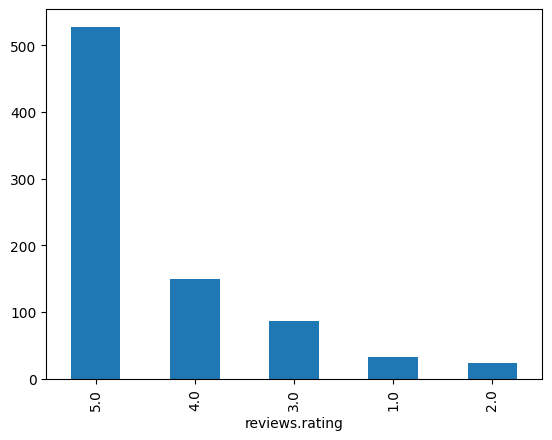

In [28]:
training_df['reviews.rating'].value_counts().plot(kind='bar')

#### Prepare for fine-tuning..

In [32]:
!openai tools fine_tunes.prepare_data --file amazon-full-train-sentiment-random.jsonl --quiet

Analyzing...

- Your file contains 1009 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 5 examples that are very long. These are rows: [99, 315, 678, 839, 1002]
For conditional generation, and for classification the examples shouldn't be longer than 2048 tokens.
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty

Based on the analysis we wil

In [41]:
!openai api fine_tunes.create -t "amazon-full-train-sentiment-random_prepared_train.jsonl" -v "amazon-full-train-sentiment-random_prepared_valid.jsonl" --compute_classification_metrics --classification_n_classes 5 -m ada --n_epochs 1

usage: openai api [-h]
                  {chat.completions.create,images.generate,images.edit,images.create_variation,audio.transcriptions.create,audio.translations.create,files.create,files.retrieve,files.delete,files.list,models.list,models.retrieve,models.delete,completions.create}
                  ...
openai api: error: argument {chat.completions.create,images.generate,images.edit,images.create_variation,audio.transcriptions.create,audio.translations.create,files.create,files.retrieve,files.delete,files.list,models.list,models.retrieve,models.delete,completions.create}: invalid choice: 'fine_tunes.create' (choose from 'chat.completions.create', 'images.generate', 'images.edit', 'images.create_variation', 'audio.transcriptions.create', 'audio.translations.create', 'files.create', 'files.retrieve', 'files.delete', 'files.list', 'models.list', 'models.retrieve', 'models.delete', 'completions.create')


### It is throwimg error here - don't know why. Will revisit soon...